<a href="https://colab.research.google.com/github/dave502/NLP/blob/main/lesson_02/nlp_hw_02.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from pandas.core.common import random_state
from matplotlib import pyplot as plt
import pandas as pd
import numpy as np
import scipy.sparse as sp
from sklearn.metrics import *
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import LabelEncoder
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.linear_model import LogisticRegression 
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer, HashingVectorizer
#from collections import defaultdict
import json
from google.colab import drive
random_state = 42
save_path = '/drive/My Drive/MLData/'

In [2]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Input, Dense, Embedding, GlobalAveragePooling1D, Conv1D, GRU, LSTM, Dropout, Flatten
from tensorflow.keras.layers.experimental.preprocessing import TextVectorization

In [6]:
%%capture
!pip install pymorphy2

In [7]:
import re
import nltk
from nltk.corpus import stopwords
from pymorphy2 import MorphAnalyzer

nltk.download('stopwords')
stopwords_list = stopwords.words("russian")

#from razdel import tokenize
#from natasha import Doc, Segmenter, MorphVocab, NewsEmbedding, NewsMorphTagger
# segmenter = Segmenter()
# morph_vocab = MorphVocab()
# emb = NewsEmbedding()
# morph_tagger = NewsMorphTagger(emb)

morph = MorphAnalyzer()

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [8]:
drive.mount('/drive')

Mounted at /drive


Получение данных

In [9]:
!wget https://www.dropbox.com/s/fnpq3z4bcnoktiv/positive.csv -nv
!wget https://www.dropbox.com/s/r6u59ljhhjdg6j0/negative.csv -nv

2022-10-14 12:36:27 URL:https://uc5128926ae371198d34e8c42838.dl.dropboxusercontent.com/cd/0/inline/Bux56MTTnDwc6NBD7w7o3V1buVv23arGCv6pgsiDUoGuSm0WoJ0e9fJgbPczmTzdZ1nS8p2oInQzNuc7dw8iWF8fKF2QHLQ6gqh1nygTJuoBQS0zDNG_YODGEiKq3fk9dlgaliAkQlEopLXDEvOSxWm87S0urPdMt7JUaD8nWt044A/file [26233379/26233379] -> "positive.csv" [1]
2022-10-14 12:36:31 URL:https://uc9c40a8b2e5781c04a13990d4b2.dl.dropboxusercontent.com/cd/0/inline/Buw0fHNs-TdAqzzAqwCqfQpWKmvzg-euFbRHnVJFFCOpwZv7hUzla9UOxgteA-x_4ubX7jmUgSslJjZCYEA4fHITCOjXmh3EqvNJZYjwm-05y-Eg0uGqRwFflpZtjZeTR6QzYh5lHXs37bdAK4eKMkr1_o2xTCPTzRIwwOUF8YOYdw/file [24450101/24450101] -> "negative.csv" [1]


Преобразование в датасет

In [10]:
positive = pd.read_csv('positive.csv', sep=';', usecols=[3], names=['text'])
negative = pd.read_csv('negative.csv', sep=';', usecols=[3], names=['text'])
positive['label'], negative['label'] = 'positive', 'negative'
df = pd.concat([positive, negative])

In [13]:
df.sample(5)

,text,label
63241,"@Satsura_ у меня предъявленное состояние, мне ...",negative
107952,"@AidaAraslanova круто!) я приеду, сто лет не б...",positive
113877,"RT @bazzzilio: @VRSoloviev :)) Я все еще жив, ...",positive
889,@BesPolotenchika давай подтягивай народ к этой...,positive
92300,"Да боже мой,какая честь! Нет тебя и нахер не н...",positive


Разделение датасета на обучающий и тестовый

In [11]:
x_train_raw, x_test_raw, y_train, y_test = train_test_split(df['text'], df['label'])

In [57]:
%%capture
!pip install razdel
!pip install natasha

Чтобы не терять каждый раз время на нормализацию текста, нормализация делается сразу:

In [61]:
def preprocessing(df_text, get_list=False):

  # С Natasha работать оказалось сложнее, чем с pymorphy2
  # def lemmatize(text):
  #   doc = Doc(text)
  #   doc.segment(segmenter)
  #   doc.tag_morph(morph_tagger)
  #   for token in doc.tokens:
  #     token.lemmatize(morph_vocab)
  #   return [_.lemma for _ in doc.tokens]

  def lemmatize(text):
    # удлание ников, знаков препинаний, чисел и т.п.
    patterns = r'@[\w]*|[^\w\s]|[^a-zA-ZА-Яа-я]'
    text = re.sub(patterns, ' ', text)
    tokens = []
    for token in text.split():
        if token and token not in stopwords_list and len(token)>1:
            token = token.strip().lower()
            token = morph.normal_forms(token)[0]
            tokens.append(token)

    tokens = " ".join(tokens) if not get_list else tokens
    return tokens

  return df_text.apply(lemmatize)


In [155]:
%%time
x_train = preprocessing(x_train_raw)
x_test = preprocessing(x_test_raw)

CPU times: user 5min 17s, sys: 910 ms, total: 5min 18s
Wall time: 5min 19s


In [156]:
x_train[:5]

24321          спасибо весь поздравлениять безумно приятно
75556    говорить мой двор кроме сегодня один человек у...
15656    после кинуть плюрк побежать жайк сюда окончате...
89586                                            думать эт
77606       ну умудриться потянуть нога второй день болеть
Name: text, dtype: object

In [158]:
x_train.to_csv(save_path+'x_train')
x_test.to_csv(save_path+'x_test')
y_train.to_csv(save_path+'y_train')
y_test.to_csv(save_path+'y_test')

**Задание 1.<br>
обучите три классификатора: <br>
1) на токенах с высокой частотой<br>
2) на токенах со средней частотой<br>
3) на токенах с низкой частотой<br>
Сравните полученные результаты, оцените какие токены наиболее важные для классификации.**

Функция классификации текста

In [168]:
def text_classifier(train_text, train_labels, test_text, test_labels, vectorizer, print_report=False):
  # получаем мешок слов
  bow = vectorizer.fit_transform(train_text)

  # с помощью логистическойй регрессии делаем предикт
  clf = LogisticRegression(n_jobs=8)
  clf.fit(bow, train_labels)
  pred = clf.predict(vectorizer.transform(test_text))

  if print_report: print(classification_report(pred, y_test))
  
  # возвращаем даннные предикта и метрику f1
  return pred, f1_score(pred, test_labels, pos_label='positive')

Из мешка слов получаем значения частот токенов

In [160]:
def get_token_frequencies(text):
  bow = CountVectorizer().fit_transform(text)
  return list(set(bow.data))

df_freq = get_token_frequencies(x_train)
print(f'частота встречающихся токенов: {df_freq}')

частота встречающихся токенов: [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 17, 23]


Выбираем векторайзеры, виды изспользуемых нграм и полученные частоты токенов делим на редкие, средние и частые

In [161]:
vectorizers = {CountVectorizer: 'CountVectorizer', TfidfVectorizer:'TfidfVectorizer'}
ngram_ranges = {(1, 1): '1gram', (2, 2):'2gram', (3, 3):'3gram'}
frequency_df = {(1, df_freq[len(df_freq)//3]): 'низкая частота',
                (df_freq[len(df_freq)//3+1], df_freq[len(df_freq)//3*2]): 'средняя частота', 
                (df_freq[len(df_freq)//3*2+1], 1.0): 'высокая частота'}
frequency_df

{(1, 6): 'низкая частота',
 (7, 11): 'средняя частота',
 (12, 1.0): 'высокая частота'}

Классификация текста

In [162]:
%%time
results = dict()  # словарь с результатами классификации
for vectorizer, vec_legend in vectorizers.items(): # перебор векторайзеров
  results_ngram = dict()
  for ngram, ngram_legend in ngram_ranges.items(): # перебор ngram
      results_df = dict()
      for (min_df, max_df), freq_legend in frequency_df.items(): # перебор частот токенов
          _, results_df[freq_legend] = text_classifier(x_train, y_train, x_test, y_test, vectorizer(min_df=min_df, max_df=max_df, ngram_range=ngram))
      results_ngram[ngram_legend]=results_df
  results[vec_legend]=results_ngram

with open('dict_results.json', 'w') as file:
    json.dump(results, file)

CPU times: user 1min 37s, sys: 2.42 s, total: 1min 39s
Wall time: 2min 55s


Отображение результата

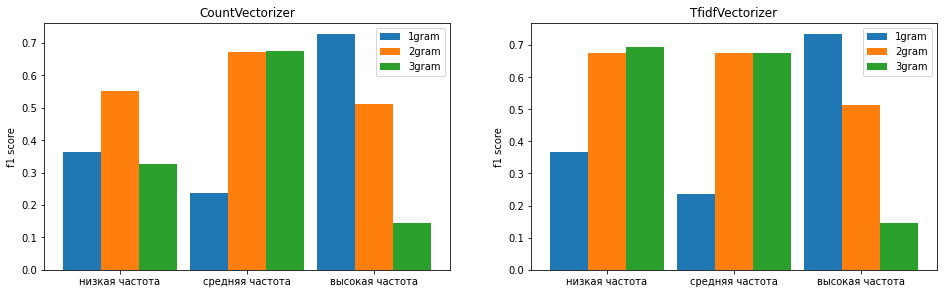

In [163]:
plt.figure(figsize=(16, 10))
for i, (vec_title, vec_result) in enumerate(results.items()):
  plt.subplot(2, 2, i+1)
  plt.title(vec_title)
  plt.ylabel('f1 score')
  x = np.arange(3)
  width = 0.3
  for i, (ngram_title, ngram_result) in enumerate(vec_result.items()):

    plt.bar(x + (0.3*i)-0.3, list(ngram_result.values()), width=width, label=ngram_title)
    plt.xticks(x, list(ngram_result.keys()))

  plt.legend()

Исходя из результатов, очевидно, что токены с высокой частотой в данном случае наиболее важные для классификации. Результаты классификации по токенам, частота которых лежит в переделах [12-23], очень близки к результатам классификации без ограничения частоты токенов. <br>
Что интересно, биграмы и триграмы показали лучший результат для токенов со средней и низкой частотой, вероятно, потому что в нграмах оказывались более частые токены. Здесь не приводятся результаты классификации ненормализованного текста, но для ненормализованного текста униграмы давали лучший результат на всех частотах. 

**Задание 2.
найти фичи с наибольшей значимостью, и вывести их**

In [164]:
count_vectorizer = CountVectorizer()
bow = count_vectorizer.fit_transform(x_train)

clf = LogisticRegression(n_jobs=8)
clf.fit(bow, y_train)

LogisticRegression(n_jobs=8)

In [165]:
feature_names = count_vectorizer.get_feature_names_out()
list(zip(feature_names, clf.coef_[0]))
sorted(list(zip(feature_names, clf.coef_[0])), key=lambda x: abs(x[1]), reverse=True)[:30]

[('xd', 4.563688553985907),
 ('dd', 4.560608215809219),
 ('ddd', 4.486376029932314),
 ('dddd', 4.444117758619806),
 ('снаступающимтвиттерский', -4.189466980064631),
 ('ddddd', 3.8615021992318033),
 ('скорбеть', -3.428402621968418),
 ('погибнуть', -3.172997866591121),
 ('теракт', -3.118010043331761),
 ('пичалька', -2.9676380002750626),
 ('luwqrs', -2.923137053757605),
 ('печально', -2.877979005335929),
 ('грустно', -2.873784004189287),
 ('печальбеда', -2.7817803859004018),
 ('огорчать', -2.7756616144606947),
 ('печаль', -2.7731876054898192),
 ('сожаление', -2.7658570206544097),
 ('хнык', -2.761727725169093),
 ('exadirectioners', -2.7586774314102076),
 ('пичалить', -2.7232629647543383),
 ('несправедливость', -2.650455703368116),
 ('улыбнуть', 2.6382576079923052),
 ('обидно', -2.6076373130498443),
 ('суждено', -2.577776037954533),
 ('печалька', -2.5635036928274624),
 ('увы', -2.536750667229971),
 ('спасииибо', 2.536683926443512),
 ('happybirthdayjaredleto', -2.473059315872398),
 ('рушитьс

**Задание 3. <br>
1) сравнить count/tf-idf/hashing векторайзеры/полносвязанную сетку (построить classification_report)<br>
2) подобрать оптимальный размер для hashing векторайзера<br>
3) убедиться что для сетки нет переобучения**

Подбор n_features для hashing векторайзера

In [ ]:
classifier = Pipeline([
    ('vectorizer', HashingVectorizer()),
    ('clf', LogisticRegression())])

param_grid = {"vectorizer__n_features": [1000, 5000, 10000, 30000, 50000, 70000, 100000]}

search = GridSearchCV(classifier, param_grid, n_jobs=8)
search.fit(x_train, y_train)

Text(0.5, 0, 'n_features')

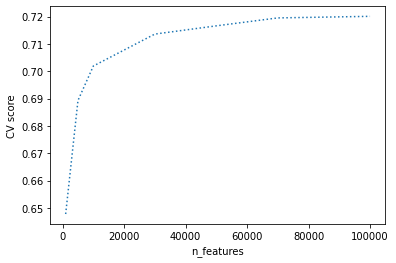

In [167]:
plt.plot(
    search.cv_results_['param_vectorizer__n_features'].data,
    search.cv_results_['mean_test_score'],
    linestyle=":"
)
plt.ylabel('CV score')
plt.xlabel('n_features')

**оптимальное количество параметров - приблизительно 70 000**

Сравение classification_report классификаторов

In [170]:
%%time
count_vectorizer = CountVectorizer()
bow = count_vectorizer.fit_transform(x_train)
clf = LogisticRegression(n_jobs=-1)
clf.fit(bow, y_train)
pred = clf.predict(count_vectorizer.transform(x_test))
print(classification_report(pred, y_test))


              precision    recall  f1-score   support

    negative       0.73      0.73      0.73     27935
    positive       0.74      0.74      0.74     28774

    accuracy                           0.73     56709
   macro avg       0.73      0.73      0.73     56709
weighted avg       0.73      0.73      0.73     56709

CPU times: user 6.71 s, sys: 216 ms, total: 6.92 s
Wall time: 14.5 s


In [171]:
%%time
Tfidf_vectorizer = TfidfVectorizer()
bow = Tfidf_vectorizer.fit_transform(x_train)
clf = LogisticRegression(n_jobs=-1)
clf.fit(bow, y_train)
pred = clf.predict(Tfidf_vectorizer.transform(x_test))
print(classification_report(pred, y_test))

              precision    recall  f1-score   support

    negative       0.70      0.74      0.72     26438
    positive       0.76      0.73      0.74     30271

    accuracy                           0.73     56709
   macro avg       0.73      0.73      0.73     56709
weighted avg       0.73      0.73      0.73     56709

CPU times: user 5.8 s, sys: 62.6 ms, total: 5.86 s
Wall time: 11.4 s


In [172]:
%%time
hashing_vectorizer = HashingVectorizer(n_features=70000)
bow = hashing_vectorizer.fit_transform(x_train)
clf = LogisticRegression(n_jobs=-1)
clf.fit(bow, y_train)
pred = clf.predict(hashing_vectorizer.transform(x_test))
print(classification_report(pred, y_test))

              precision    recall  f1-score   support

    negative       0.70      0.73      0.71     26670
    positive       0.75      0.72      0.73     30039

    accuracy                           0.72     56709
   macro avg       0.72      0.72      0.72     56709
weighted avg       0.72      0.72      0.72     56709

CPU times: user 4.73 s, sys: 24.4 ms, total: 4.76 s
Wall time: 9.98 s


NN

In [56]:
positive = pd.read_csv('positive.csv', sep=';', usecols=[3], names=['text'])
negative = pd.read_csv('negative.csv', sep=';', usecols=[3], names=['text'])
positive['label'], negative['label'] = 'positive', 'negative'
x_train, x_test, y_train, y_test = train_test_split(df['text'], df['label'])

Разбиваем обучающую выборку на обучающущю и валидационую

In [57]:
nnx_train, nnx_valid, nny_train, nny_valid = train_test_split(x_train, y_train)

Нормализация

In [63]:
nnx_train = preprocessing(nnx_train)
nnx_valid = preprocessing(nnx_valid)

In [64]:
# labelEncode целевую переменную
encoder = LabelEncoder()
nny_train = encoder.fit_transform(nny_train)
nny_valid = encoder.fit_transform(nny_valid)

train_data = tf.data.Dataset.from_tensor_slices((nnx_train, nny_train))
valid_data = tf.data.Dataset.from_tensor_slices((nnx_valid, nny_valid))

train_data = train_data.batch(16)
valid_data = valid_data.batch(16)

AUTOTUNE = tf.data.AUTOTUNE
train_data = train_data.cache().prefetch(buffer_size=AUTOTUNE)
valid_data = valid_data.cache().prefetch(buffer_size=AUTOTUNE)


In [65]:
def custom_standardization(input_data):
    return input_data

vocab_size = 10000
seq_len = 100

vectorize_layer = TextVectorization(
    standardize=custom_standardization,
    max_tokens=vocab_size,
    output_mode='int',
    output_sequence_length=seq_len)

# Make a text-only dataset (no labels) and call adapt to build the vocabulary.
text_data = train_data.map(lambda x, y: x)
vectorize_layer.adapt(text_data)

In [125]:
embedding_dim=100

10*100*200

model = Sequential([
    vectorize_layer,
    Embedding(vocab_size, embedding_dim),
    Dropout(0.2),
    GlobalAveragePooling1D(),
    Dropout(0.2),
    # Conv1D(200, (3)),
    # Conv1D(200, (2)),
    # GRU(300),
    #GlobalAveragePooling1D(),
    Dense(100, activation='relu'),
    Dense(1)
])

In [135]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
              metrics=tf.metrics.BinaryAccuracy(threshold=0.5))

In [136]:
history = model.fit(train_data, validation_data=valid_data, epochs=5)

Epoch 1/5
7975/7975 [==============================] - 65s 5ms/step - loss: 0.4658 - binary_accuracy: 0.7614 - val_loss: 0.5823 - val_binary_accuracy: 0.7121
Epoch 2/5
7975/7975 [==============================] - 36s 5ms/step - loss: 0.4600 - binary_accuracy: 0.7651 - val_loss: 0.5865 - val_binary_accuracy: 0.7131
Epoch 3/5
7975/7975 [==============================] - 36s 5ms/step - loss: 0.4534 - binary_accuracy: 0.7702 - val_loss: 0.5920 - val_binary_accuracy: 0.7132
Epoch 4/5
7975/7975 [==============================] - 36s 5ms/step - loss: 0.4466 - binary_accuracy: 0.7748 - val_loss: 0.5989 - val_binary_accuracy: 0.7096
Epoch 5/5
7975/7975 [==============================] - 38s 5ms/step - loss: 0.4396 - binary_accuracy: 0.7795 - val_loss: 0.6092 - val_binary_accuracy: 0.7128


Нормализация тестового датафрейма

In [69]:
nnx_test = preprocessing(x_test)
nny_test = encoder.fit_transform(y_test)

Получаем предикт модели

In [137]:
pred = model.predict(nnx_test)

1773/1773 [==============================] - 4s 2ms/step


In [145]:
pred[:5] # Ожидался результат в диапазоне от 0 до 1. Не ясно почему так.

array([[-0.07786962],
       [-5.875721  ],
       [-9.053772  ],
       [ 1.879563  ],
       [ 0.3813364 ]], dtype=float32)

Преобразуем предикт в двоичный результат

In [140]:
pred_binary = pred>0.5

Получаем classification_report

In [144]:
print(classification_report(pred_binary, nny_test))

              precision    recall  f1-score   support

       False       0.80      0.68      0.73     32976
        True       0.63      0.76      0.69     23733

    accuracy                           0.71     56709
   macro avg       0.71      0.72      0.71     56709
weighted avg       0.73      0.71      0.71     56709



**Результаты у сетки получились не самые лучшие. У каунт векторайзера и tf-idf векторайзера получились лучше. Но надо признать, что сетка в плане конфигурации и настройки очень недоработана.**

Проверка переобучения

In [147]:
history_dict = history.history

Графики потерь при обучении и валидации

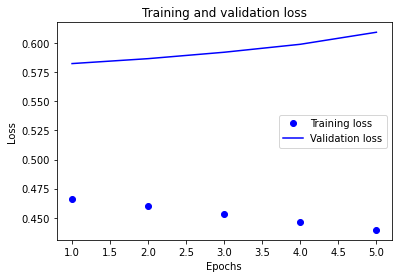

In [148]:
acc = history_dict['binary_accuracy']
val_acc = history_dict['val_binary_accuracy']
loss = history_dict['loss']
val_loss = history_dict['val_loss']

epochs = range(1, len(acc) + 1)

# "bo" is for "blue dot"
plt.plot(epochs, loss, 'bo', label='Training loss')
# b is for "solid blue line"
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()


Графики точности при обучении и валидации

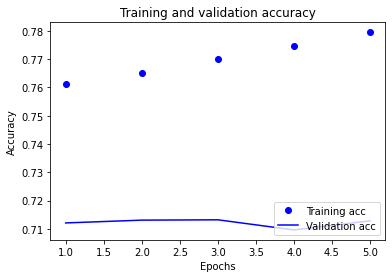

In [149]:
plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')

plt.show()


**Судя по графикам, модель немного переобучилась**